#Importing required libraries for analysis of data

In [0]:
# Import external libraries
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
!pip3 install seaborn==0.9.0
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
sns.set_style('whitegrid')
from sklearn.utils import shuffle

%matplotlib inline

In [0]:
# Check that version 0.9.0 is loaded for Seaborn
sns.__version__

'0.9.0'

## Importing data from CSV file

In [0]:
# Read churn data from csv
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv") 
# Preview the first 5 lines of the loaded data 
data.drop('customerID',axis=1, inplace=True)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Processing data

In [0]:
# Check types of data in dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


In [0]:
# Convert TotalCharges to numeric values
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


In [0]:
# Check for NaN values in data
print(data.isna().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [0]:
# Number of entries with NaN values is negligible (11), drop from data set
data.dropna(inplace=True)
data.shape

(7032, 20)

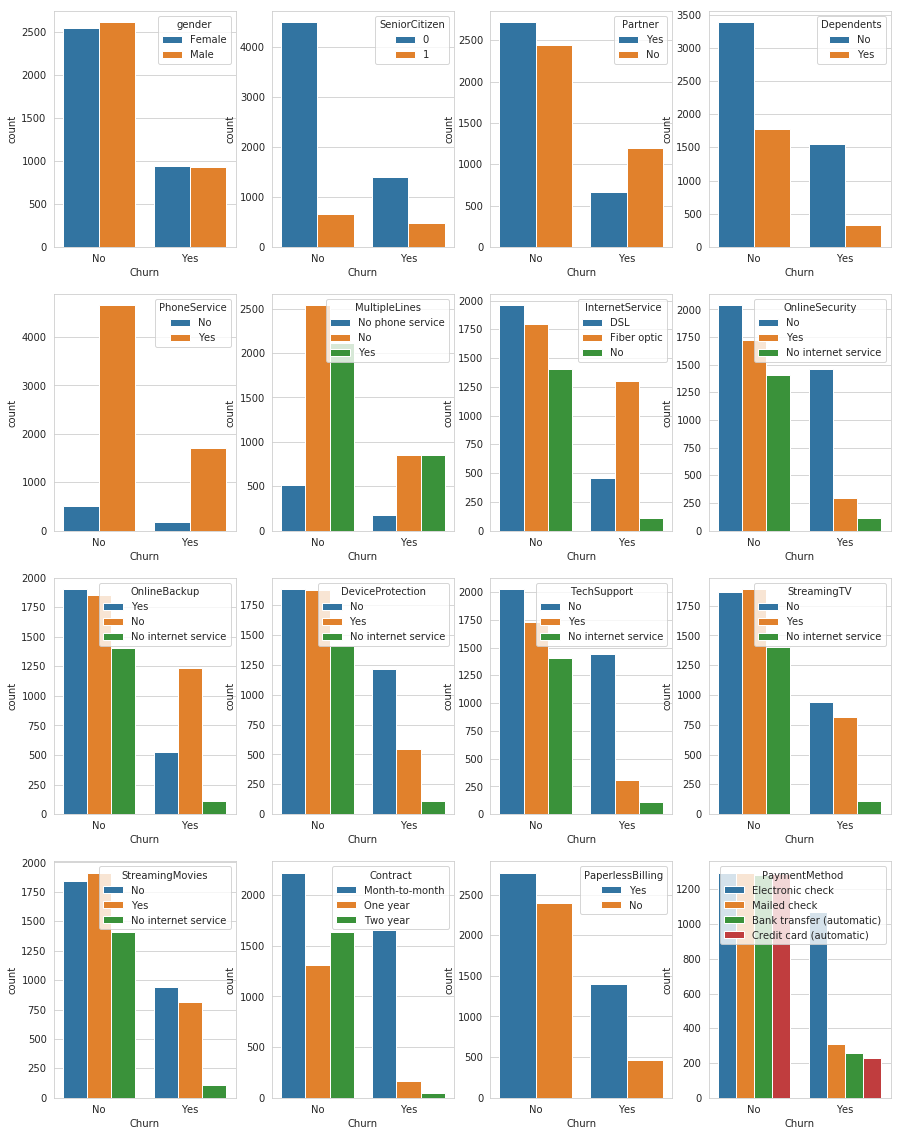

In [0]:
# Plot each feature against Churn to see which may have highest impact
fig,axes = plt.subplots(4,4,squeeze=True,figsize=(15,20))
axes = axes.flatten()

skipped_categories = ['TotalCharges','MonthlyCharges','tenure','Churn']

index = 0
for feature in data.columns:
  # Checking feature distibution on churn
  if feature not in skipped_categories:
    sns.catplot('Churn',data=data,kind='count',hue=feature,ax=axes[index])
    plt.close()
    index += 1
fig.show()


Based on the above charts, it appears that OnlineSecurity, Electronic check payment, Fiber optic internet service, and month-to-month contracts are the most directly tied to churn. We will investigate further though and run correlation on further normalized data.

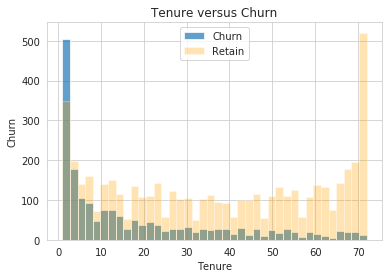

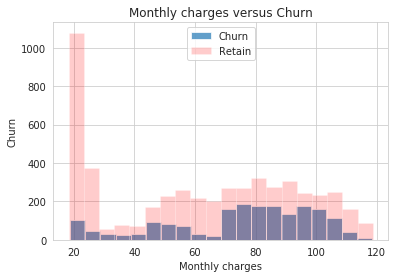

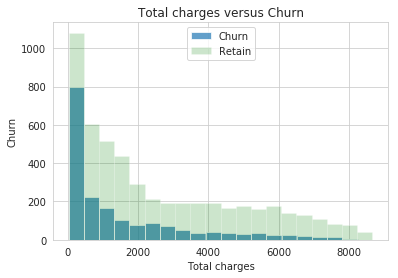

In [0]:
# Create dataframes for customers who did churn (yes_churn) and did not (no_churn)
yes_churn = data[data['Churn']=="Yes"]
no_churn = data[data['Churn']=="No"]

# Plot a histogram against tenure
plt.hist(yes_churn['tenure'],bins=40,alpha=0.7,label="Churn")
plt.hist(no_churn['tenure'],bins=40,alpha=0.3,color='orange',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Tenure')
plt.ylabel('Churn')
plt.title('Tenure versus Churn')
plt.show()

# Plot a histogram against monthly charges
plt.hist(yes_churn['MonthlyCharges'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['MonthlyCharges'],bins=20,alpha=0.2,color='red',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Monthly charges')
plt.ylabel('Churn')
plt.title('Monthly charges versus Churn')
plt.show()

# Plot a histogram against total charges
plt.hist(yes_churn['TotalCharges'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['TotalCharges'],bins=20,alpha=0.2,color='green',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Total charges')
plt.ylabel('Churn')
plt.title('Total charges versus Churn')
plt.show()

(7032, 21)


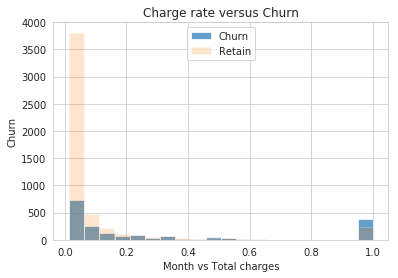

In [0]:
# Create new metric for Monthly versus Total charges
data['month_v_total_charge'] = data['MonthlyCharges']/data['TotalCharges']
print(data.shape)

# Refresh churn data with new metric
yes_churn = data[data['Churn']=="Yes"]
no_churn = data[data['Churn']=="No"]

# Plot a histogram against monthly versus total charges
plt.hist(yes_churn['month_v_total_charge'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['month_v_total_charge'],bins=20,alpha=0.2,label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Month vs Total charges')
plt.ylabel('Churn')
plt.title('Charge rate versus Churn')
plt.show()

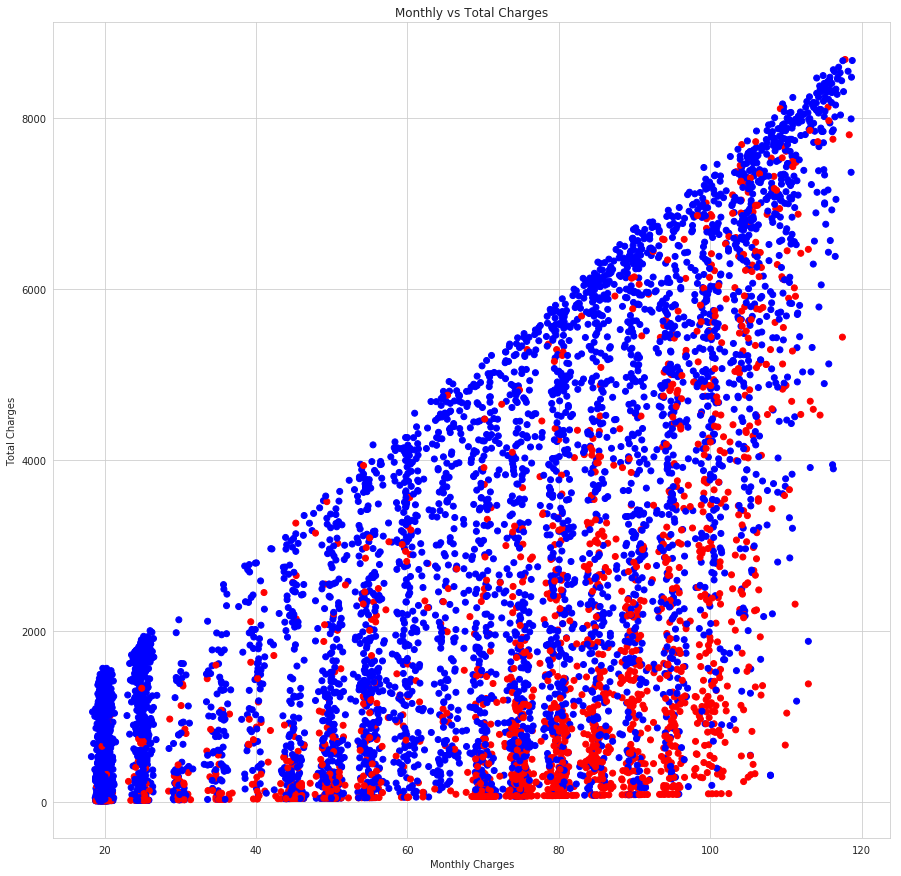

In [0]:
color= ['red' if l == "Yes" else 'blue' for l in data['Churn']]
plt.figure(figsize=(15,15))
plt.scatter(data['MonthlyCharges'],data['TotalCharges'],color=color)
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.title('Monthly vs Total Charges')
plt.show()

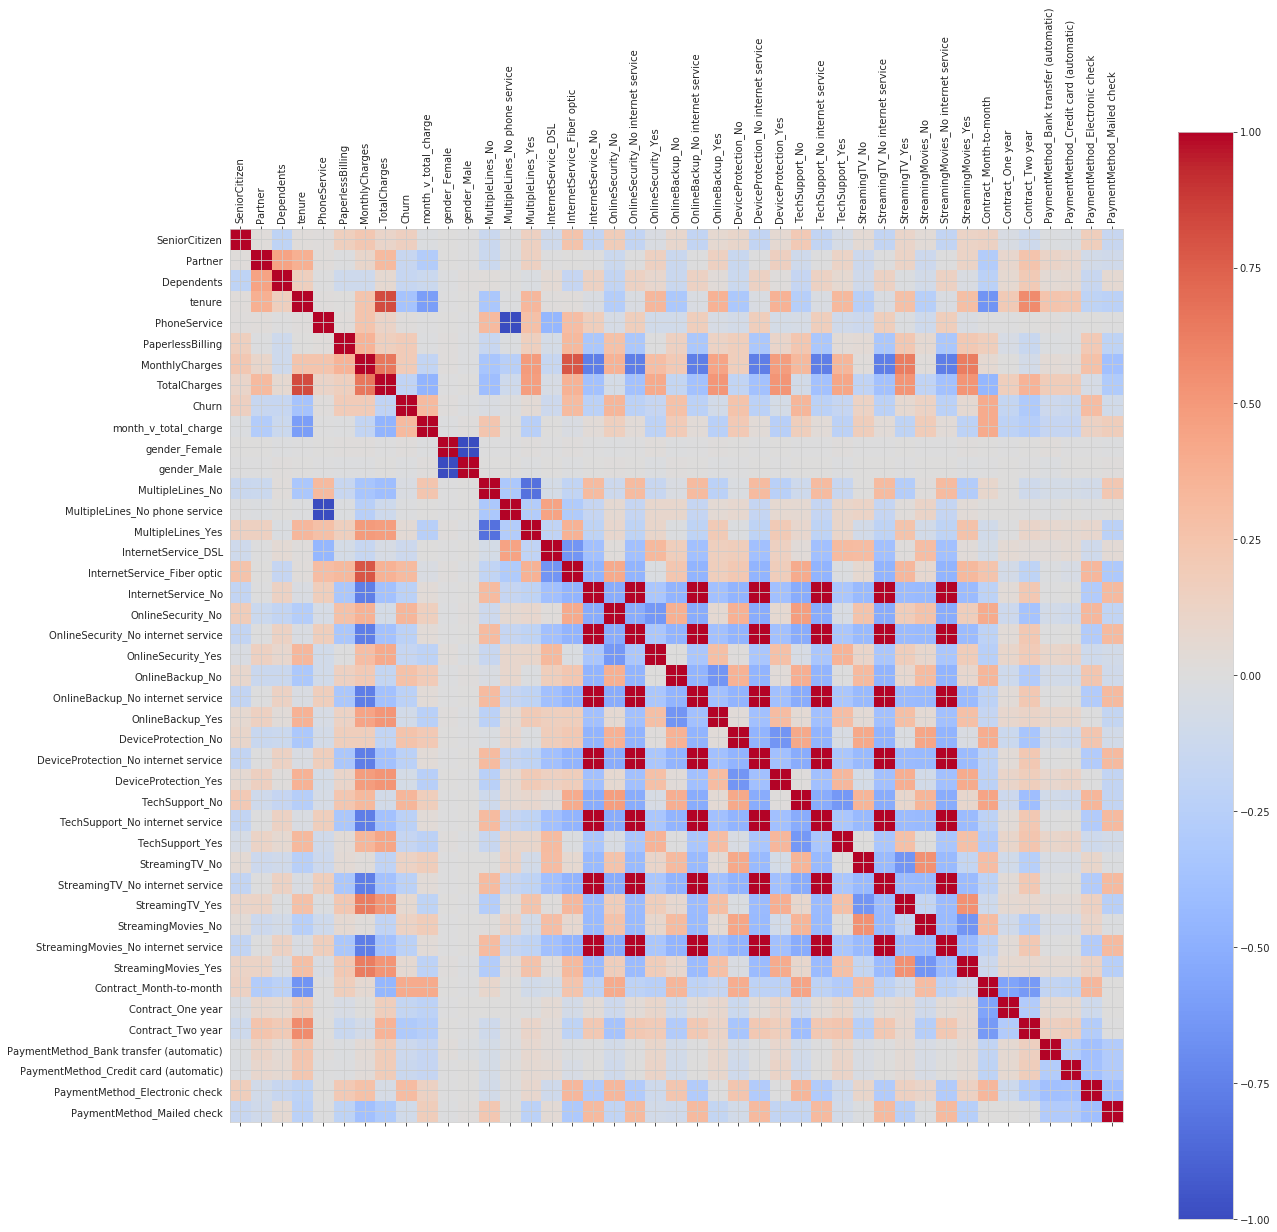

In [0]:
# Encode the data to numeric values for analysis
yes_no_columns = ['Partner','Dependents','PhoneService','PaperlessBilling',
                  'Churn']

dummies_columns = ['gender','MultipleLines','InternetService','OnlineSecurity',
                   'OnlineBackup','DeviceProtection','TechSupport',
                   'StreamingTV','StreamingMovies','Contract','PaymentMethod']

for header in yes_no_columns:
  data[header].replace({"Yes":1,'No':0},inplace=True)

encoded_data = pd.get_dummies(data,columns=dummies_columns)

corr = encoded_data.corr()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0,len(encoded_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(encoded_data.columns)
ax.set_yticklabels(encoded_data.columns)
plt.show()

In [0]:
# Print out correlation values for Churn in sorted order
sorted_churn_correlation = corr['Churn'].sort_values(ascending=False)
print(sorted_churn_orrelation)
plt.plot(sorted_churn_correlation)

This confirms that the top contributing factors to churn are:

 1) Month-to-month contract
 
 2) No online security
 
 3) No tech support
 
 4) Monthly versus total charge amounts
 
 5) Fiber optic internet service

In [0]:
pos_churn_test = pos_churn_df.loc[:249,columns]
print(pos_churn_test.shape)
neg_churn_test = neg_churn_df.loc[:749,columns]
print(neg_churn_test.shape)
churn_test = pd.concat([pos_churn_test,neg_churn_test])
print(churn_test.shape)

(250, 7)
(750, 7)
(1000, 7)


In [0]:
churn_df = pd.concat([pos_churn_df,neg_churn_df])
print(churn_df.shape)


(7043, 7)


                  Partner  Dependents    Tenure  InternetService  \
Partner          1.000000    0.452676  0.273580         0.000851   
Dependents       0.452676    1.000000  0.132112        -0.052010   
Tenure           0.273580    0.132112  1.000000         0.000670   
InternetService  0.000851   -0.052010  0.000670         1.000000   
OnlineSecurity  -0.091303    0.029721 -0.152333         0.427891   
Contract         0.294806    0.243187  0.386828        -0.055352   
Churn           -0.150448   -0.164221 -0.308539         0.124214   

                 OnlineSecurity  Contract     Churn  
Partner               -0.091303  0.294806 -0.150448  
Dependents             0.029721  0.243187 -0.164221  
Tenure                -0.152333  0.386828 -0.308539  
InternetService        0.427891 -0.055352  0.124214  
OnlineSecurity         1.000000 -0.015824 -0.023309  
Contract              -0.015824  1.000000 -0.396713  
Churn                 -0.023309 -0.396713  1.000000  


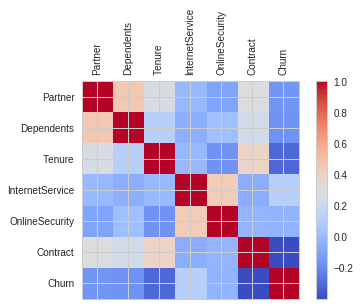

In [0]:
corr = churn_df.corr()
print(corr)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0,len(churn_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(churn_df.columns)
ax.set_yticklabels(churn_df.columns)
plt.show()

In [0]:
# adapted from http://matplotlib.org/examples/specialty_plots/hinton_demo.html
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)

    ax.autoscale_view()
    ax.invert_yaxis()

hinton(churn_df.as_matrix())

AttributeError: ignored